In [1]:
# Data manipulation
import time
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

# KERAS
from keras import Sequential, Input, layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras.datasets import boston_housing

# Fine-Tune your Neural Network and Save it

## (0) The Boston Housing Dataset

### (0.1) Loading the Dataset

In [2]:
# Loading the dataset
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

# Shape of the dataset:
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(((404, 13), (404,)), ((102, 13), (102,)))

### (0.2) Quick Glance at the Target

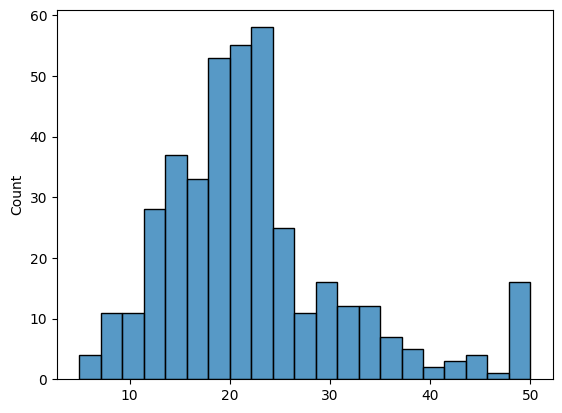

In [4]:
# Distribution of the houses' prices in the training set
sns.histplot(y_train)
plt.show()

In [5]:
# Null values and types of each feature:
pd.DataFrame(X_train).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       404 non-null    float64
 1   1       404 non-null    float64
 2   2       404 non-null    float64
 3   3       404 non-null    float64
 4   4       404 non-null    float64
 5   5       404 non-null    float64
 6   6       404 non-null    float64
 7   7       404 non-null    float64
 8   8       404 non-null    float64
 9   9       404 non-null    float64
 10  10      404 non-null    float64
 11  11      404 non-null    float64
 12  12      404 non-null    float64
dtypes: float64(13)
memory usage: 41.2 KB


In [6]:
# Statistics about the numerical columns
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000


### (0.3) Minimal Data Preprocessing

In [7]:
# Scaling
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### (0.4) Baseline Model

In [8]:
y_pred = np.mean(y_train)
print(f'The mean prediction is {y_pred:.3f}')

absolute_error_test_baseline = [np.abs(y_true - y_pred) for y_true in y_test]
mean_absolute_error_test_baseline = np.mean(absolute_error_test_baseline)

print(f'The benchmark mean absolute error is {mean_absolute_error_test_baseline:.3f}')

The mean prediction is 22.395
The benchmark mean absolute error is 6.533


## (1) The Neural Network

In [12]:
def initialize_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[-1], ))) # recommended above instead of shape=(13,)
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(7, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    return model

model = initialize_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 10)             │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │            77 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

## (2) The Optimizer

In [13]:
def compile_model(model, optimizer_name):
    model.compile(loss='mse', optimizer=optimizer_name, metrics=['mae'])

    return model

### Evaluating the Model

In [14]:
model = compile_model(initialize_model(), 'adam')

es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.3,
    shuffle=True,
    batch_size=16,
    epochs=1000,
    callbacks=[es],
    verbose=0
)

res = model.evaluate(X_test_scaled, y_test)[1]
res

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 26.8830 - mae: 2.9617 


2.9616661071777344

### Neural Network vs. Baseline

In [15]:
mae_test_baseline = mean_absolute_error_test_baseline
mae_test_neuralnet = res

print(f"The MAE on the test is {mae_test_neuralnet:.4f} for the Neural Network vs. {mae_test_baseline:.4f} for the baseline")

The MAE on the test is 2.9617 for the Neural Network vs. 6.5330 for the baseline


### (2.1) Which Optimizer is the Best?

In [16]:
def plot_loss_mae(history):
    # Setting figures
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))

    # Create the plots
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])

    ax2.plot(history.history['mae'])
    ax2.plot(history.history['val_mae'])

    # Set titles and labels
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    ax2.set_title('MAE')
    ax2.set_ylabel('MAE')
    ax2.set_xlabel('Epoch')

    # Set limits for y-axes
    ax1.set_ylim(ymin=0, ymax=200)
    ax2.set_ylim(ymin=0, ymax=20)

    # Generate legends
    ax1.legend(['Train', 'Validation'], loc='best')
    ax2.legend(['Train', 'Validation'], loc='best')

    # Show grids
    ax1.grid(axis="x", linewidth=0.5)
    ax1.grid(axis="y", linewidth=0.5)

    ax2.grid(axis="x", linewidth=0.5)
    ax2.grid(axis="y", linewidth=0.5)

    plt.show()

In [17]:
def plot_loss_mse(history):
    # Setting figures
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))

    # Create the plots
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])

    ax2.plot(history.history['mse'])
    ax2.plot(history.history['val_mse'])

    # Set titles and labels
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    ax2.set_title('MSE')
    ax2.set_ylabel('MSE')
    ax2.set_xlabel('Epoch')

    # Set limits for y-axes
    ax1.set_ylim(ymin=0, ymax=20)
    ax2.set_ylim(ymin=0, ymax=200)

    # Generate legends
    ax1.legend(['Train', 'Validation'], loc='best')
    ax2.legend(['Train', 'Validation'], loc='best')

    # Show grids
    ax1.grid(axis="x", linewidth=0.5)
    ax1.grid(axis="y", linewidth=0.5)

    ax2.grid(axis="x", linewidth=0.5)
    ax2.grid(axis="y", linewidth=0.5)

    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 27.2684 - mae: 2.9569 
Test MAE with the rmsprop optimizer: 2.9569  reached in 46 s after 393 epochs


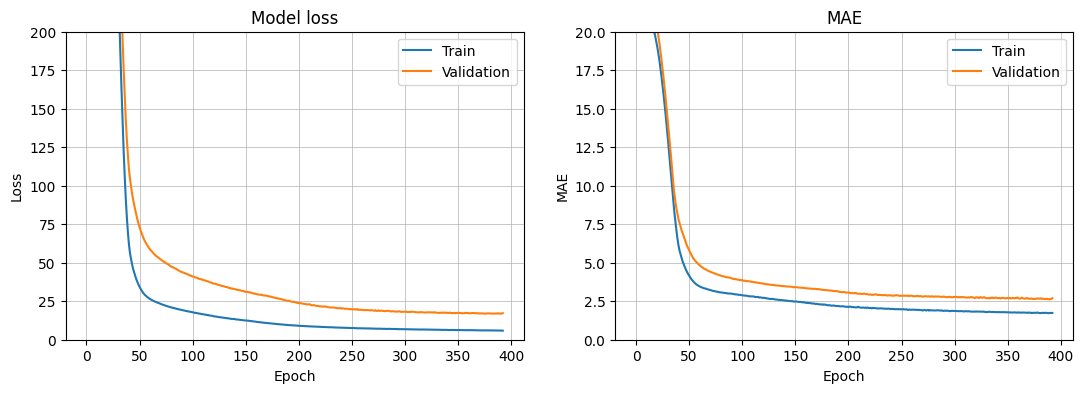

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 23.1960 - mae: 3.0928 
Test MAE with the adam optimizer: 3.0928  reached in 33 s after 284 epochs


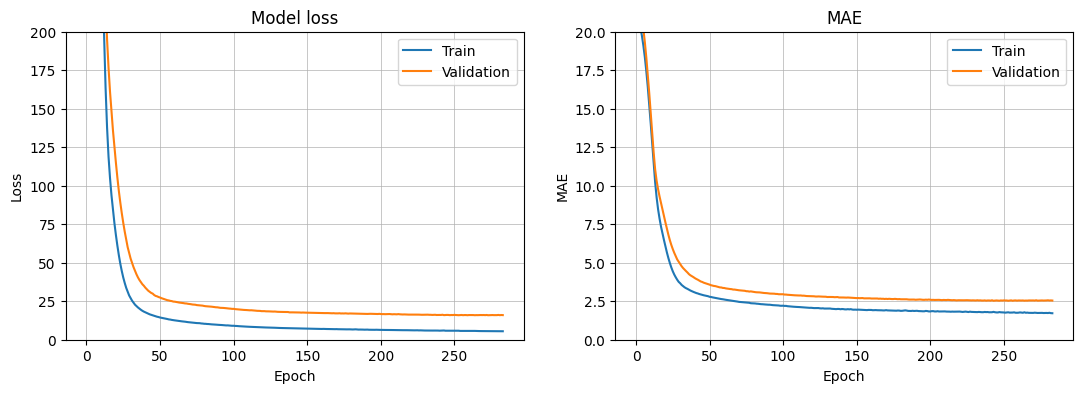

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 450.4196 - mae: 19.0384 
Test MAE with the adagrad optimizer: 19.0384  reached in 55 s after 500 epochs


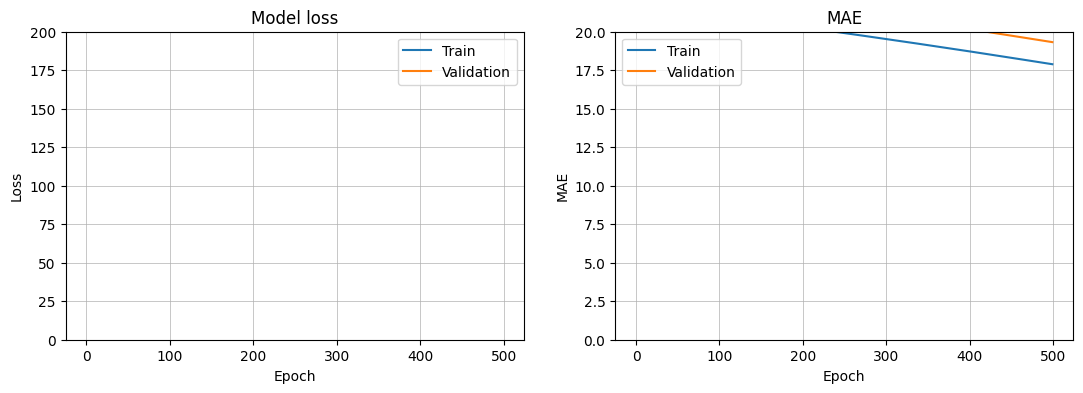

In [18]:
results = []

for optimizer in ['rmsprop', 'adam', 'adagrad']:
    start_time = time.time()

    model = compile_model(initialize_model(), optimizer)

    es = EarlyStopping(patience=10, restore_best_weights=True)

    history = model.fit(
        X_train_scaled,
        y_train,
        batch_size=16,
        epochs=500,
        validation_split=0.3,
        callbacks=[es],
        verbose=0
    )

    res = model.evaluate(X_test_scaled, y_test)[1]
    results.append(res)

    end_time = time.time()

    print(f'Test MAE with the {optimizer} optimizer: {res:.4f}  reached in {(end_time - start_time):.0f} s after {len(history.epoch)} epochs')
    plot_loss_mae(history)

### Neural Network vs. Baseline - part 2

In [19]:
# MAE on the testing set for different optimizers
for optimizer, result in zip(['rmsprop', 'adam', 'adagrad'], results):
    print(f"The MAE on the test set with the {optimizer} optimizer is equal to {result:.2f}")

# MAE on the testing set for the baseline model
print("-"*5)
print(f"The MAE on the test set with the baseline model is equal to {mae_test_baseline:.2f}")

The MAE on the test set with the rmsprop optimizer is equal to 2.96
The MAE on the test set with the adam optimizer is equal to 3.09
The MAE on the test set with the adagrad optimizer is equal to 19.04
-----
The MAE on the test set with the baseline model is equal to 6.53


### (2.2) The Influence of the Learning Rate

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 23.1130 - mae: 3.6872 
Test Mean Absolute Error with a learning rate of 0.1: 3.6872


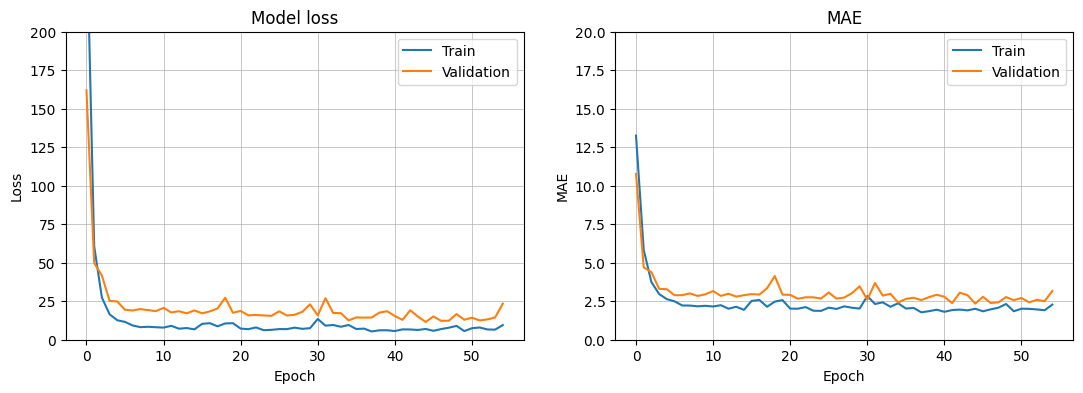

In [20]:
# 1. Instantiating the Adam optimizer with a learning rate alpha = 0.1
adam = Adam(learning_rate=0.1)

# 2. Initializing the model
model = initialize_model()

# 3. Compiling the model with the custom Adam optimizer
model = compile_model(model, adam)

# 4. Training the neural net
es = EarlyStopping(patience=10)
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.3,
    shuffle= True,
    batch_size=16,
    epochs=1_000,
    callbacks=[es],
    verbose=0
)

# 5. Plot the history and evaluate the model
res = model.evaluate(X_test_scaled, y_test)[1]
res
print(f'Test Mean Absolute Error with a learning rate of 0.1: {res:.4f}')
plot_loss_mae(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.8977 - mae: 3.0338
Test MAE with a learning rate of 0.0001 --> 3.0338


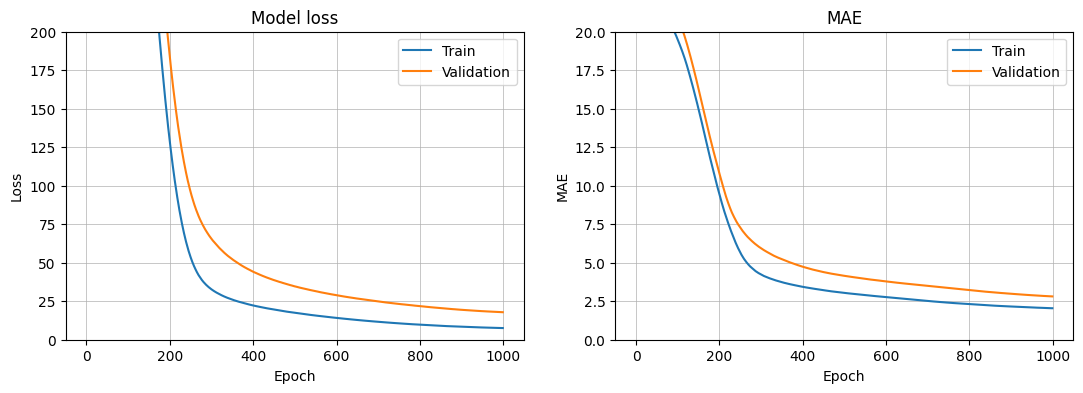

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 22.5361 - mae: 2.9544
Test MAE with a learning rate of 0.001 --> 2.9544


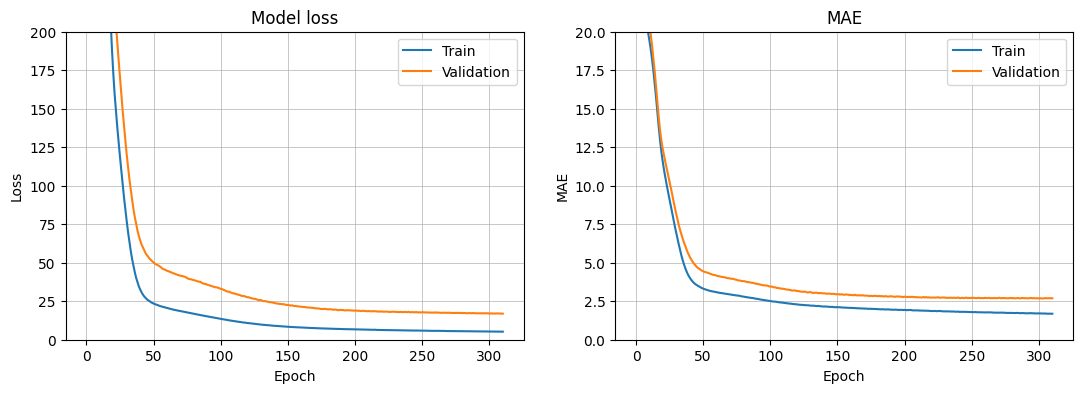

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 24.4957 - mae: 3.1050 
Test MAE with a learning rate of 0.01 --> 3.1050


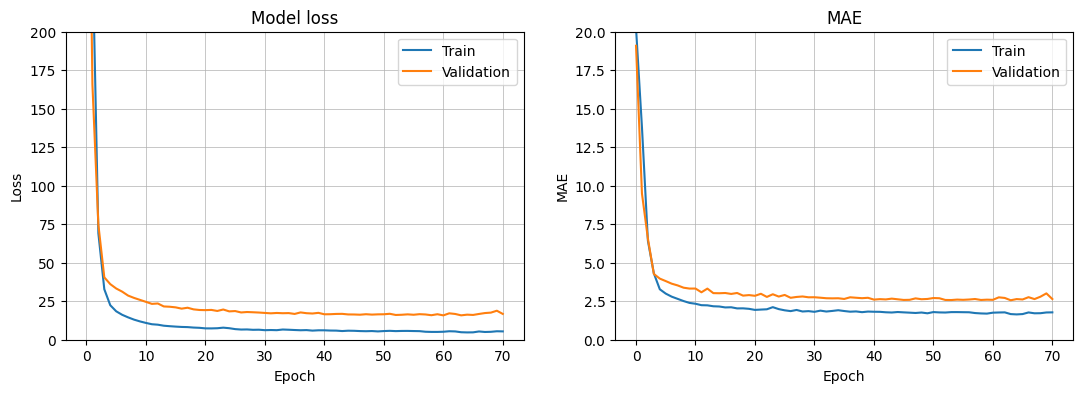

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 20.0629 - mae: 3.0654 
Test MAE with a learning rate of 0.1 --> 3.0654


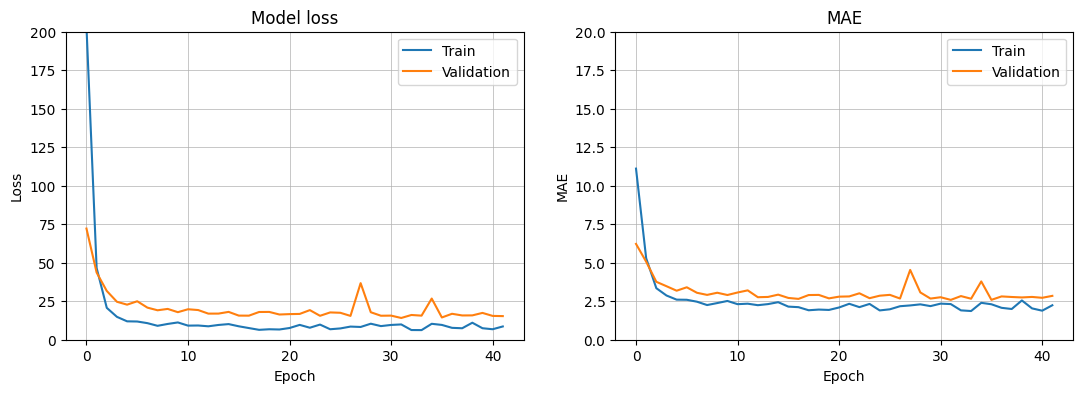

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 85.3142 - mae: 6.5251 
Test MAE with a learning rate of 1.0 --> 6.5251


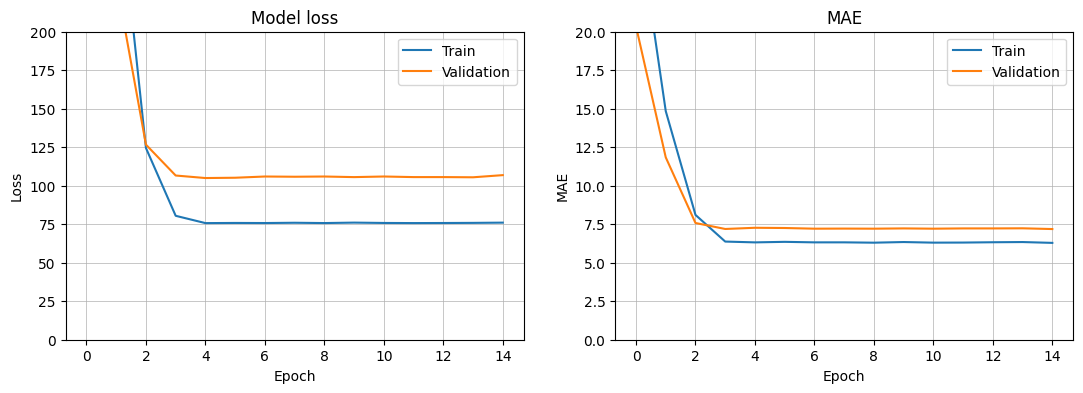

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 84.5463 - mae: 6.5137 
Test MAE with a learning rate of 2.0 --> 6.5137


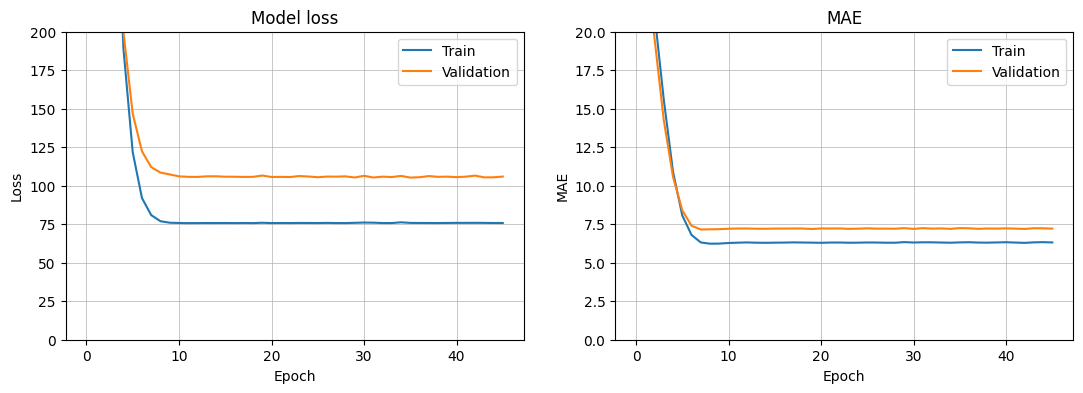

In [21]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1.0, 2.0]
results = []

for learning_rate in learning_rates:
    # 1. Instantiating the Adam optimizer with a specific learning_rate
    adam = Adam(learning_rate=learning_rate)

    # 2. Initializing the model
    model = initialize_model()

    # 3. Compiling the model with the custom Adam optimizer
    model = compile_model(model, adam)

    # 4. Training the neural net
    es = EarlyStopping(patience=10)
    history = model.fit(
        X_train_scaled,
        y_train,
        validation_split=0.3,
        shuffle=True,
        batch_size=16,
        epochs=1_000,
        callbacks=[es],
        verbose=0
    )

    # 5. Plot the history and evaluate the model
    res = model.evaluate(X_test_scaled, y_test)[1]
    results.append(res)

    print(f'Test MAE with a learning rate of {learning_rate} --> {res:.4f}')
    plot_loss_mae(history)

## (3) The Loss

In [22]:
### First, optimizing the Mean Absolute error

model = initialize_model()
model.compile(loss='mae', optimizer='adam', metrics=['mse'])

es = EarlyStopping(patience=10)
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.3,
    shuffle=True,
    batch_size=16,
    epochs=1_000,
    callbacks=[es],
    verbose=0
)

res = model.evaluate(X_test_scaled, y_test)

print(f"MAE_train : {min(history.history['loss']):.4f} - MSE_train : {min(history.history['mse']):.4f}")
print(f"MAE_val : {min(history.history['val_loss']):.4f} - MSE_val : {min(history.history['val_mse']):.4f}")
print(f"MAE_test : {res[0]:.4f} - MSE_test : {res[1]:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7200 - mse: 16.1908
MAE_train : 1.8193 - MSE_train : 9.5631
MAE_val : 2.8520 - MSE_val : 26.8092
MAE_test : 2.7200 - MSE_test : 16.1908


In [23]:
### Second, optimizing the Mean Squared Error
model = initialize_model()
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

es = EarlyStopping(patience=10)
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.3,
    shuffle=True,
    batch_size=16,
    epochs=1_000,
    callbacks=[es],
    verbose=0
)

res = model.evaluate(X_test_scaled, y_test)

res = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"MAE_train : {min(history.history['mae']):.4f} - MSE_train : {min(history.history['loss']):.4f}")
print(f"MAE_val : {min(history.history['val_mae']):.4f} - MSE_val : {min(history.history['val_loss']):.4f}")
print(f"MAE_test : {res[1]:.4f} - MSE_test : {res[0]:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 20.9852 - mae: 2.9448
MAE_train : 1.7014 - MSE_train : 5.4905
MAE_val : 2.5424 - MSE_val : 16.0621
MAE_test : 2.9448 - MSE_test : 20.9852


## (4) Saving and Loading a Trained Neural Network

In [ ]:
model = Sequential()
model.add(Input(shape=(X_train.shape[-1],)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

initial_learning_rate = 0.01

# We can decrease the Learning Rate progressively as the network
# converges; more details on that in the optional section! Students
# are not expected to implement the Exponential Decay here unless
# they are already familiar with it, but I doubt it!

lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=2000,
    decay_rate=0.5
)

adam = Adam(learning_rate=lr_schedule)

model = compile_model(model, adam)

es = EarlyStopping(patience=20)

history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.3,
    shuffle=True,
    batch_size=16,
    epochs=1000,
    callbacks=[es],
    verbose=0
)

plot_loss_mae(history)

mae_test = model.evaluate(X_test_scaled, y_test)[1]
mae_test

In [ ]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'solution',
    mae_test=mae_test
)

result.write()
print(result.check())

In [ ]:
model.save_model(model, 'my_beautiful_model.keras')

!ls *.keras

In [ ]:
loaded_model = models.load_model('my_beautiful_model.keras')
loaded_model

In [ ]:
loaded_model.summary()

In [ ]:
res_from_loaded_model = loaded_model.evaluate(X_test_scaled, y_test, verbose=0)[1]
res_from_loaded_model

In [ ]:
res_from_loaded_model == mae_test